In [265]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [233]:
df = pd.read_excel("base_a_traiter.xlsx")
df = df[df["Compagnie"] != "SNCF"]
df["Month"] = df["Date_aller"].apply(lambda date:date.month)
df["Week"] = df["Date_aller"].apply(lambda date:date.week)
df.columns

Index(['Compagnie', 'Total d'escales', 'Destination', 'Distance', 'Date_aller',
       'Date_retour', 'Prix', 'Duree de vol', 'Month', 'Week'],
      dtype='object')

# Preprocessing

<ipython-input-259-ed80937f8877>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg["y_standard"] = preprocessing.scale(df_reg["Prix"])


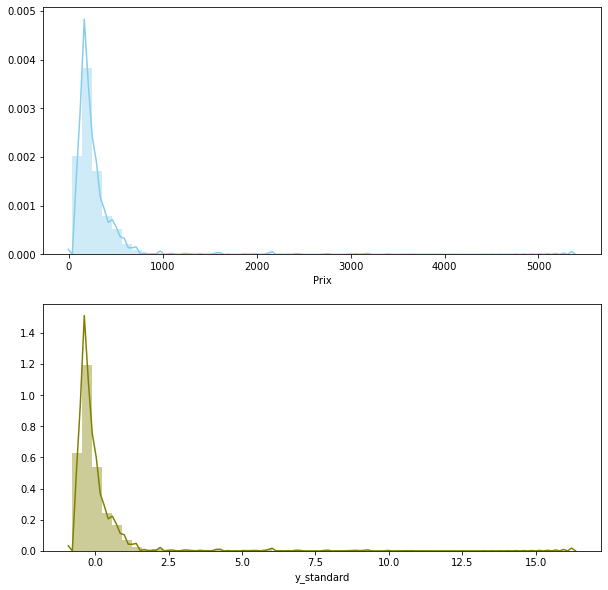

In [259]:
from sklearn import preprocessing
xvars = ["Distance", "Total d'escales", "Duree de vol", "Month", "Week", "Compagnie"] # Variables explicatives
df_reg = df[["Prix"] + xvars]
df_reg["y_standard"] = preprocessing.scale(df_reg["Prix"])
df_reg.dropna(how = "any")
f, axes = plt.subplots(2, figsize=(10, 10))
sns.distplot(df_reg["Prix"] , color="skyblue", ax=axes[0])
sns.distplot(df_reg["y_standard"] , color="olive", ax=axes[1]) #On vérifie que la distribution est centrée et que sa variamnce empirique vaut 1

In [260]:
df_regb = df[xvars].drop(columns = ["Compagnie"])
scaler = preprocessing.StandardScaler().fit(df_regb)
X1 = scaler.transform(df_regb)
print(X1, type(X1))


[[ 0.09296303 -0.99070019 -0.72113654 -1.61865839 -1.89399015]
 [ 0.09296303 -0.99070019 -0.66487368 -1.61865839 -1.89399015]
 [ 0.09296303 -0.99070019 -0.69300511 -1.61865839 -1.89399015]
 ...
 [-1.40662309 -0.99070019 -1.0305823   1.25787309  1.42210998]
 [-1.40662309 -0.99070019 -1.05871373  1.25787309  1.42210998]
 [-1.40662309 -0.99070019 -1.08684516  1.25787309  1.42210998]] <class 'numpy.ndarray'>


In [261]:
df_regc = df_reg["Compagnie"].astype(str)
df_regc.dropna(how = "any")


label_enc = preprocessing.LabelEncoder().fit(df_regc)
X2 = label_enc.transform(df_regc)
X2 = np.array([X2]).T
print(X2, type(X2))


[[ 8]
 [ 8]
 [20]
 ...
 [ 8]
 [14]
 [ 8]] <class 'numpy.ndarray'>


# Régression linéaire

In [246]:
xvars = ["Distance", "Total d'escales", "Duree de vol", "Month", "Week", "Compagnie"] # Variables explicatives

df_reg.drop(columns = ["Compagnie"], inplace = True)
indices_to_keep = ~df_reg.isin([np.nan, np.inf, -np.inf]).any(axis = 1)
df_reg = df_reg[indices_to_keep].astype(np.float64)
X = np.concatenate((X1, X2), axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, df_reg[["y_standard"]].values.ravel(), test_size = 0.2, random_state = 0)
ols = LinearRegression().fit(X_train, y_train)
y_pred = ols.predict(X_test)
y_pred[:10]
print(ols.intercept_, ols.coef_, y_pred)

0.20266604833900126 [ 0.31587899  0.08532973 -0.03126642 -0.01837672  0.09609179 -0.00891986] [-0.03994226 -0.09631807  0.38464678 ... -0.04703806 -0.07183009
 -0.20832092]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [247]:
rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
rsq = sklearn.metrics.r2_score(y_test, y_pred)
print("Mean squared error: %.2f" % rmse)
print('Coefficient of determination: %.2f' % rsq)

Mean squared error: 0.93
Coefficient of determination: 0.11


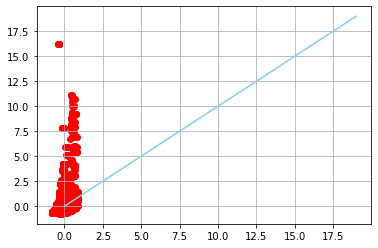

In [248]:
tempdf = pd.DataFrame({"prediction" : y_pred, "observed": y_test})
axes = plt.axes()
axes.grid()
plt.scatter(tempdf["prediction"], tempdf["observed"], color ="red")
#ax = tempdf.plot.scatter(x = "prediction", y = "observed", color = "skyblue")
plt.plot([x for x in range(20)], color = "skyblue")

# Régression linéaire à l'aide du module statsmodels

In [205]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
df = pd.read_excel("base_a_traiter.xlsx")
xvars = ["Distance", "Total d'escales", "Duree de vol", "Month", "Week", "Compagnie"] # Variables explicatives
df = df[df["Compagnie"] != "SNCF"]
df["Month"] = df["Date_aller"].apply(lambda date:date.month)
df["Week"] = df["Date_aller"].apply(lambda date:date.week)
df.dropna(how = "any")
df["Intercept"] = [1 for i in range(len(df))]
df_regc = df["Compagnie"].astype(str)
df_regc.dropna(how = "any")

label_enc = preprocessing.LabelEncoder().fit(df_regc)
X2 = label_enc.transform(df_regc)

df["Compagnie"] = X2
print(X2, type(X2))
# Récupérer l'ensemble des valeurs de la variable cible
Y = df["Prix"]
# Récupérer les variables prédictives (on en a 2)
X = df[xvars]
scale = StandardScaler()
X_scaled = scale.fit_transform(X[xvars])
est = sm.OLS(Y, X).fit()
 
print(est.summary())


[ 8  8 20 ...  8 14  8] <class 'numpy.ndarray'>
                                 OLS Regression Results                                
Dep. Variable:                   Prix   R-squared (uncentered):                   0.504
Model:                            OLS   Adj. R-squared (uncentered):              0.504
Method:                 Least Squares   F-statistic:                          1.243e+04
Date:                Mon, 27 Dec 2021   Prob (F-statistic):                        0.00
Time:                        20:43:05   Log-Likelihood:                     -5.2064e+05
No. Observations:               73278   AIC:                                  1.041e+06
Df Residuals:                   73272   BIC:                                  1.041e+06
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025 

# Régression Logistique



In [262]:
xvars = ["Distance", "Total d'escales", "Duree de vol", "Month", "Week", "Compagnie"] # Variables explicatives

df_reg.drop(columns = ["Compagnie"], inplace = True)
indices_to_keep = ~df_reg.isin([np.nan, np.inf, -np.inf]).any(axis = 1)
df_reg = df_reg[indices_to_keep].astype(np.float64)

df_reg['y'] = (df_reg['y_standard']>0.5).astype(int)

X = np.concatenate((X1, X2), axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, df_reg[["y"]].values.ravel(), test_size = 0.2, random_state = 0)
clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred[:10]
print(clf.intercept_, clf.coef_)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


[-1.50400019] [[ 1.02837088 -0.35029493  0.03331721 -0.31013538  0.5555547  -0.03886336]]


0.8929448689956332
0.39490937138449667
0.7864823348694316
0.26364572605561276


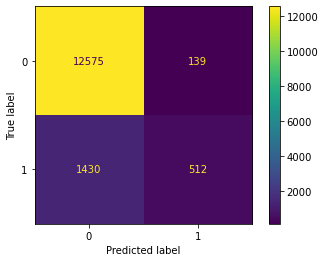

In [263]:
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

print(sc_accuracy)
print(sc_f1)
print(sc_recall)
print(sc_precision)